<a href="https://colab.research.google.com/github/SarkarPriyanshu/Machine-Learning-Models/blob/main/HR_Analytics_Job_Change_of_Data_Scientists.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Loading

In [6]:
!pip install -q feature-engine

In [7]:
! pip install -q kaggle

In [8]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [9]:
!kaggle datasets download -d arashnic/hr-analytics-job-change-of-data-scientists

  0% 0.00/295k [00:00<?, ?B/s]
100% 295k/295k [00:00<00:00, 94.9MB/s]


In [10]:
import zipfile
zip_ref = zipfile.ZipFile('hr-analytics-job-change-of-data-scientists.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [186]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from feature_engine.imputation import AddMissingIndicator
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import YeoJohnsonTransformer

from sklearn.preprocessing import StandardScaler

import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Basic Analysis

In [12]:
df = pd.read_csv('/content/aug_train.csv').drop('enrollee_id',axis=1)

In [13]:
df.shape

(19158, 13)

In [14]:
df.sample(5)

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
17745,city_160,0.920,NaN,Has relevent experience,no_enrollment,Graduate,No Major,14,NaN,NaN,1,23,0.0
14281,city_16,0.910,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,3,44,0.0
4404,city_100,0.887,Male,Has relevent experience,Part time course,Graduate,STEM,6,100-500,Pvt Ltd,3,79,0.0
7871,city_115,0.789,Female,No relevent experience,no_enrollment,Graduate,STEM,17,NaN,NaN,>4,40,0.0
18045,city_103,0.920,Male,No relevent experience,no_enrollment,Primary School,NaN,<1,NaN,NaN,never,25,0.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   gender                  14650 non-null  object 
 3   relevent_experience     19158 non-null  object 
 4   enrolled_university     18772 non-null  object 
 5   education_level         18698 non-null  object 
 6   major_discipline        16345 non-null  object 
 7   experience              19093 non-null  object 
 8   company_size            13220 non-null  object 
 9   company_type            13018 non-null  object 
 10  last_new_job            18735 non-null  object 
 11  training_hours          19158 non-null  int64  
 12  target                  19158 non-null  float64
dtypes: float64(2), int64(1), object(10)
memory usage: 1.9+ MB


In [16]:
df['target'] = df['target'].astype(int)

In [17]:
df.isnull().sum() / df.shape[0] * 100

city                       0.000000
city_development_index     0.000000
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
last_new_job               2.207955
training_hours             0.000000
target                     0.000000
dtype: float64

In [18]:
df.duplicated().sum()

49

In [19]:
df.describe()

,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000
mean,0.828848,65.366896,0.249348
std,0.123362,60.058462,0.432647
min,0.448000,1.000000,0.000000
25%,0.740000,23.000000,0.000000
50%,0.903000,47.000000,0.000000
75%,0.920000,88.000000,0.000000
max,0.949000,336.000000,1.000000


## EDA

### UniVariant Analysis

#### Numeric Columns Analysis

In [20]:
numeric_feature = [feature for feature in df.columns if (df[feature].dtype == int or df[feature].dtype == float) and feature != 'target']
categorical_feature = [feature for feature in df.columns if (df[feature].dtype == object) and feature != 'target']
target = [feature for feature in df.columns if feature == 'target']

<ipython-input-21-226e1262580e>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature], ax=ax3)


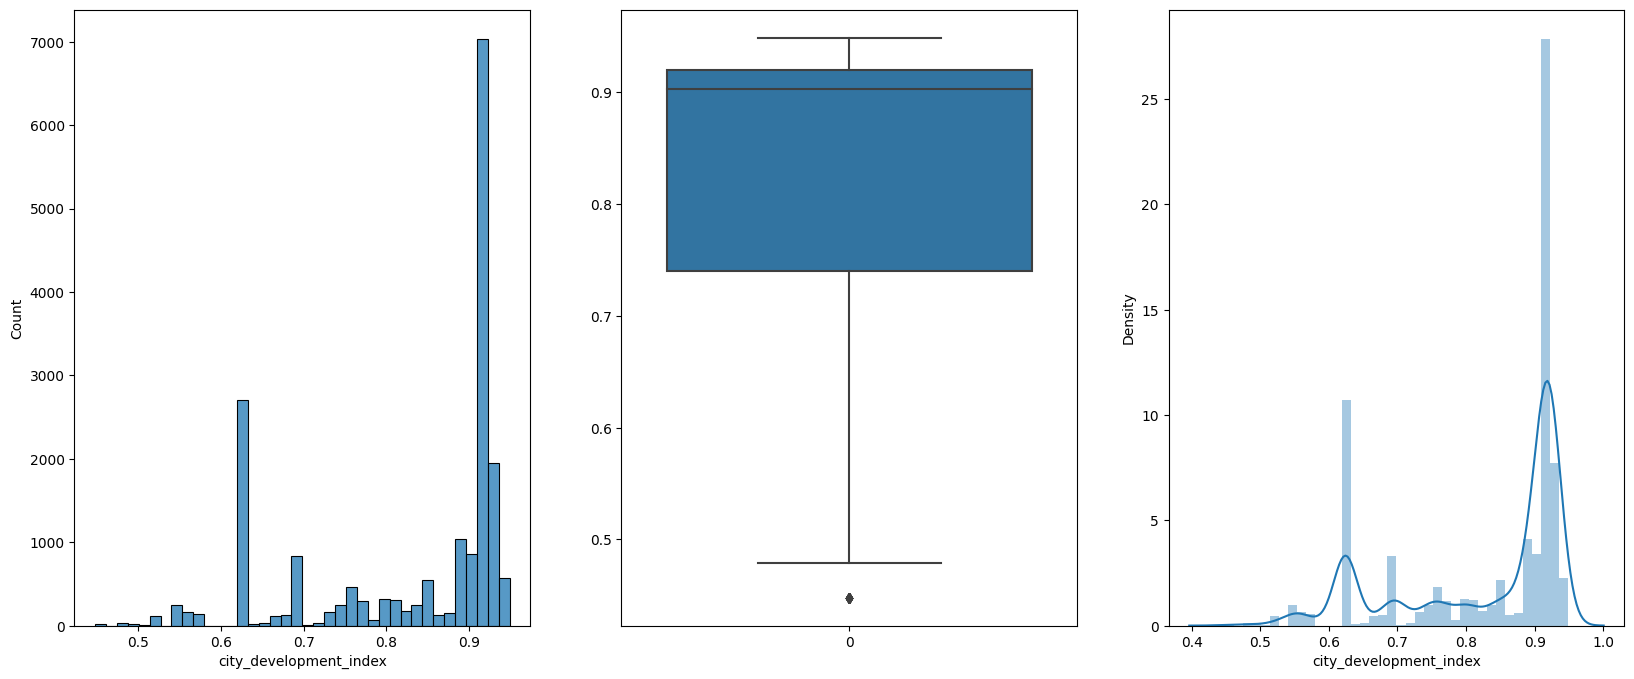

<ipython-input-21-226e1262580e>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature], ax=ax3)


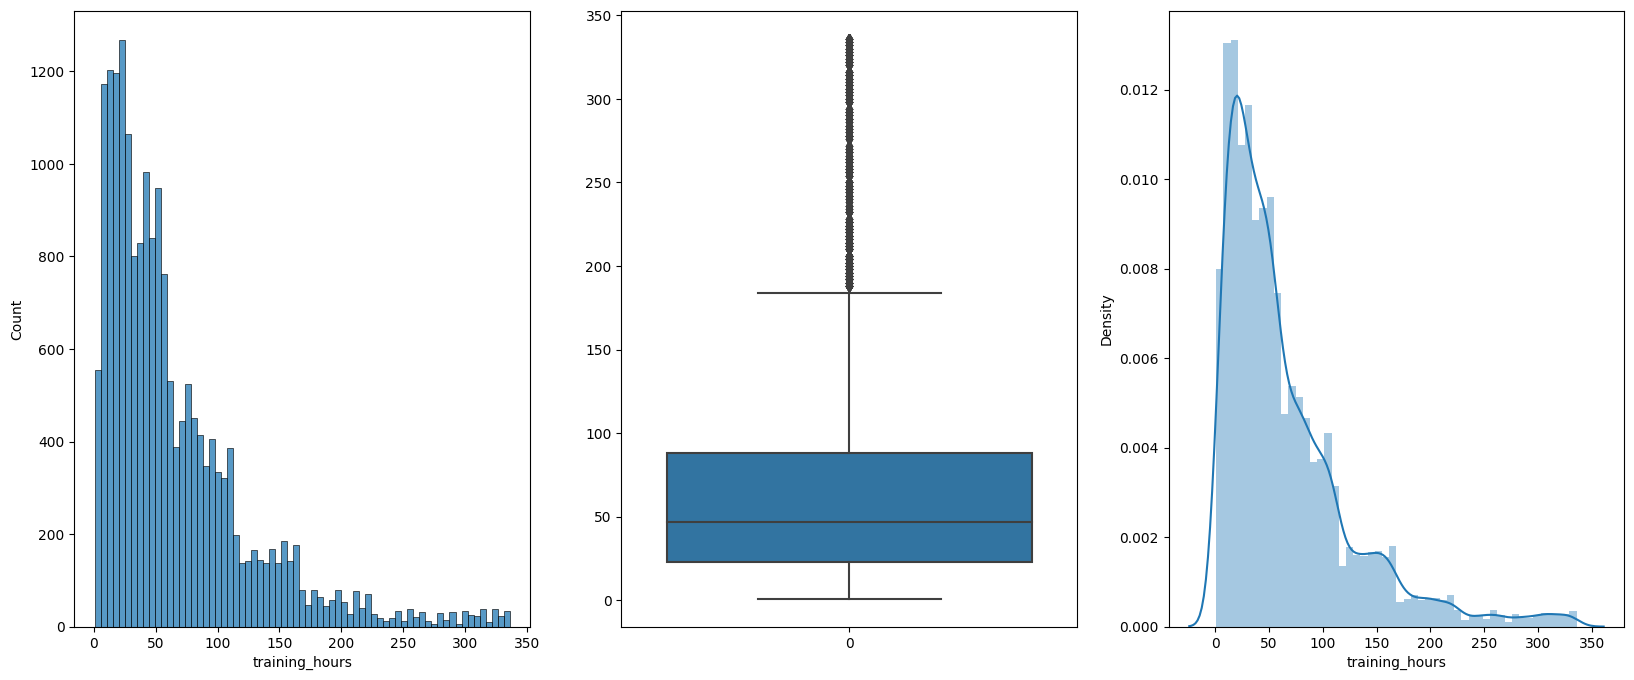

In [21]:
for feature in numeric_feature:
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,8))
    sns.histplot(df[feature], ax=ax1)
    sns.boxplot(df[feature], ax=ax2)
    sns.distplot(df[feature], ax=ax3)
    plt.show()

#### Categorical Columns Analysis

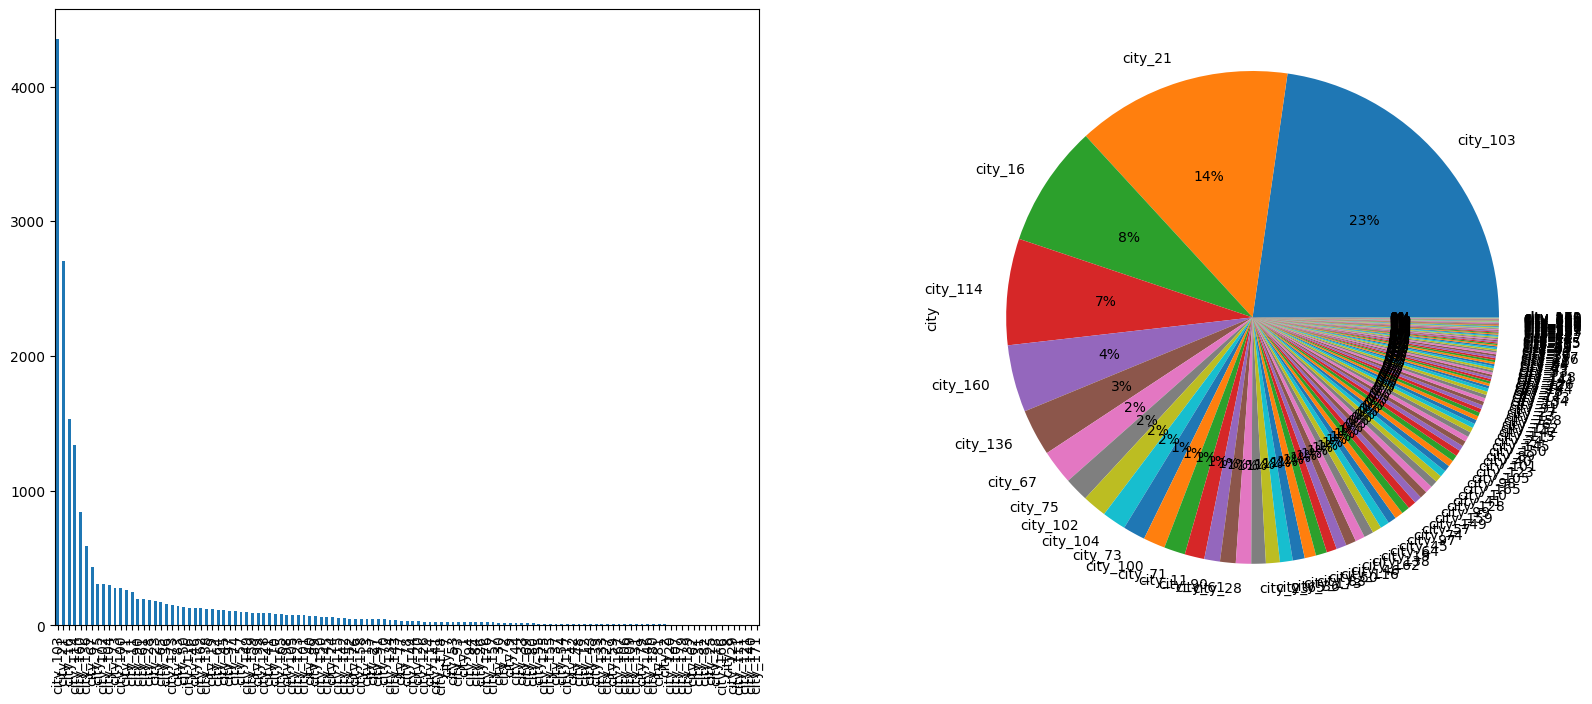

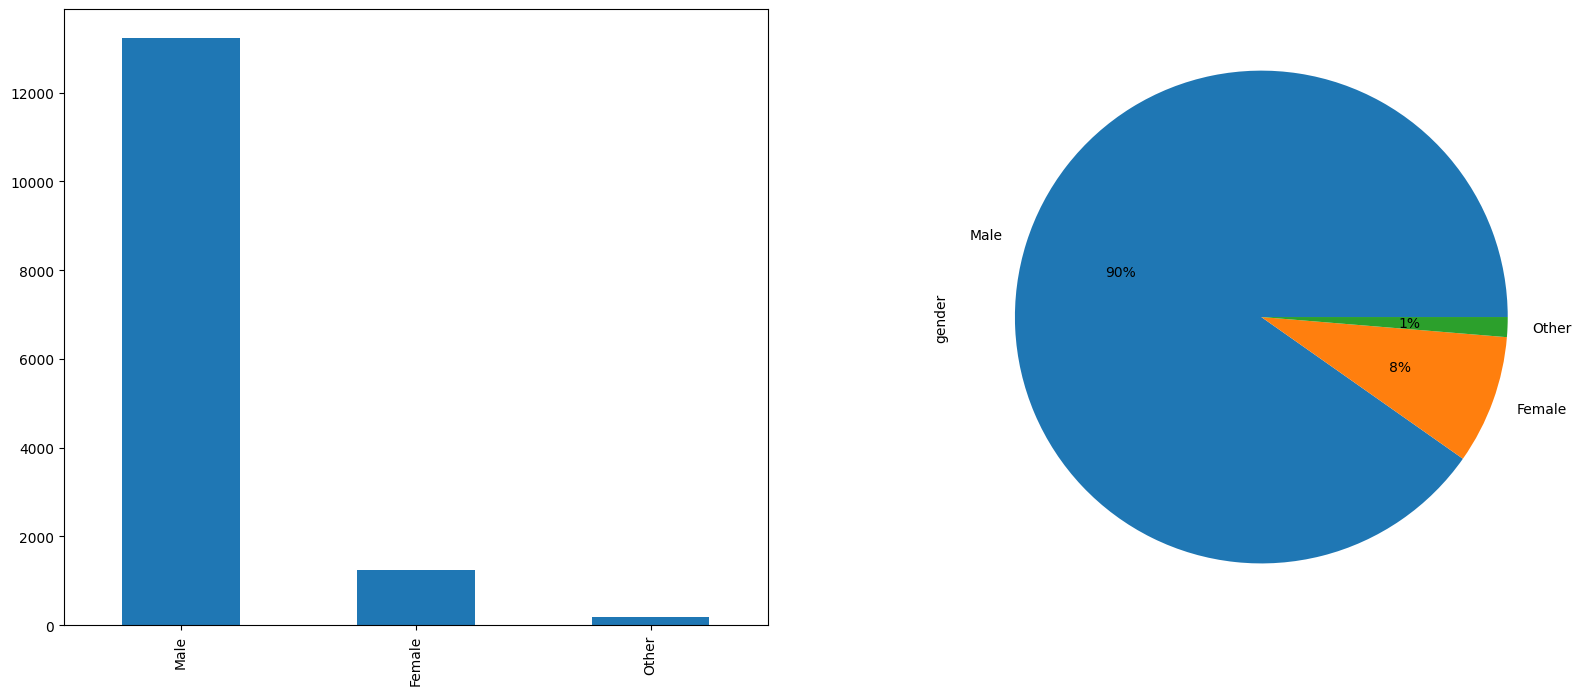

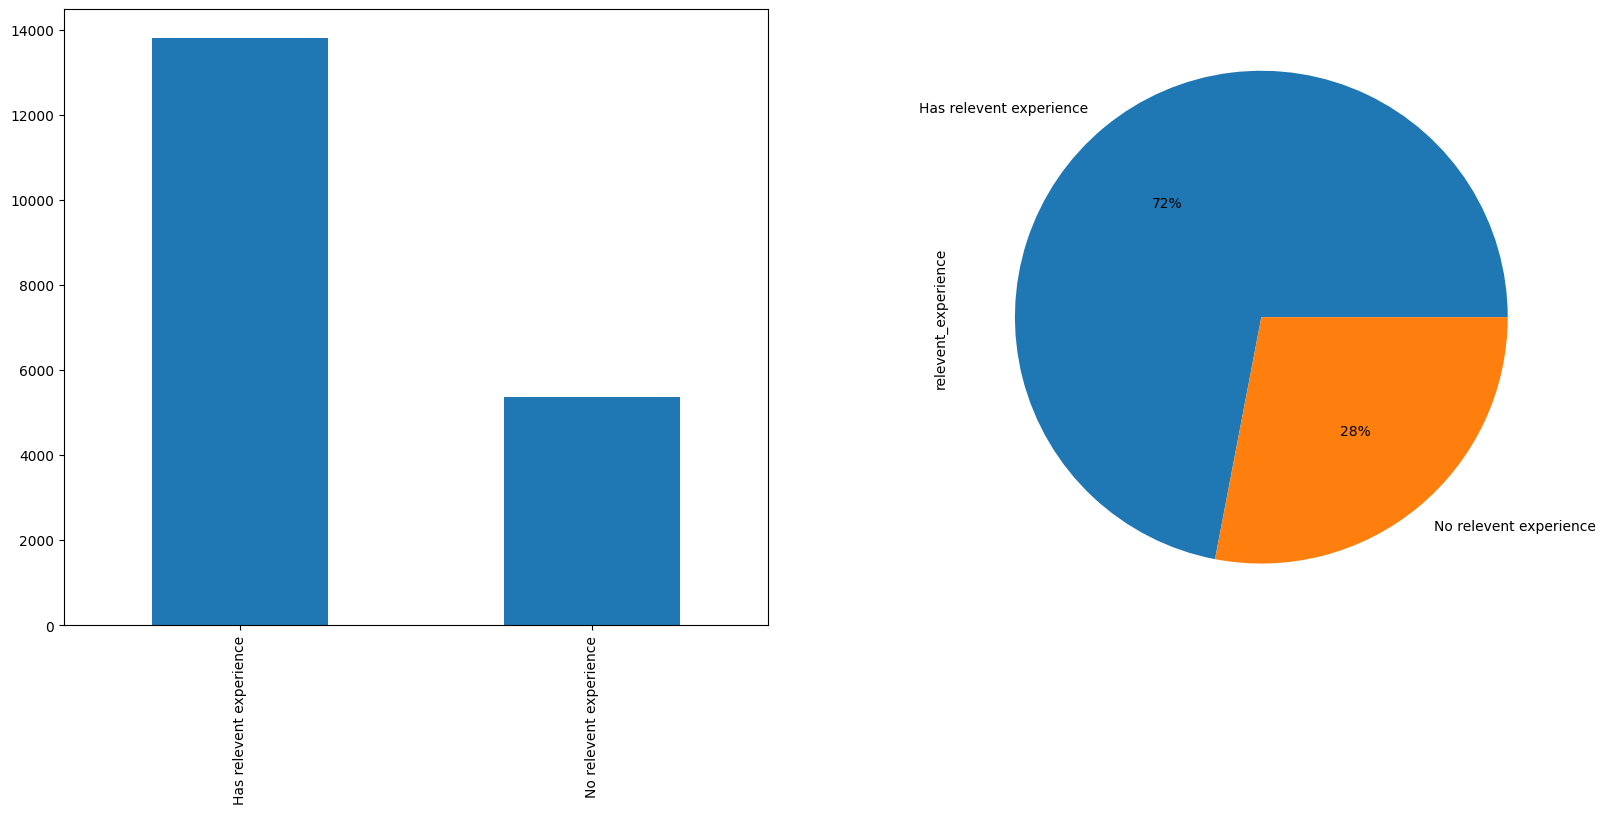

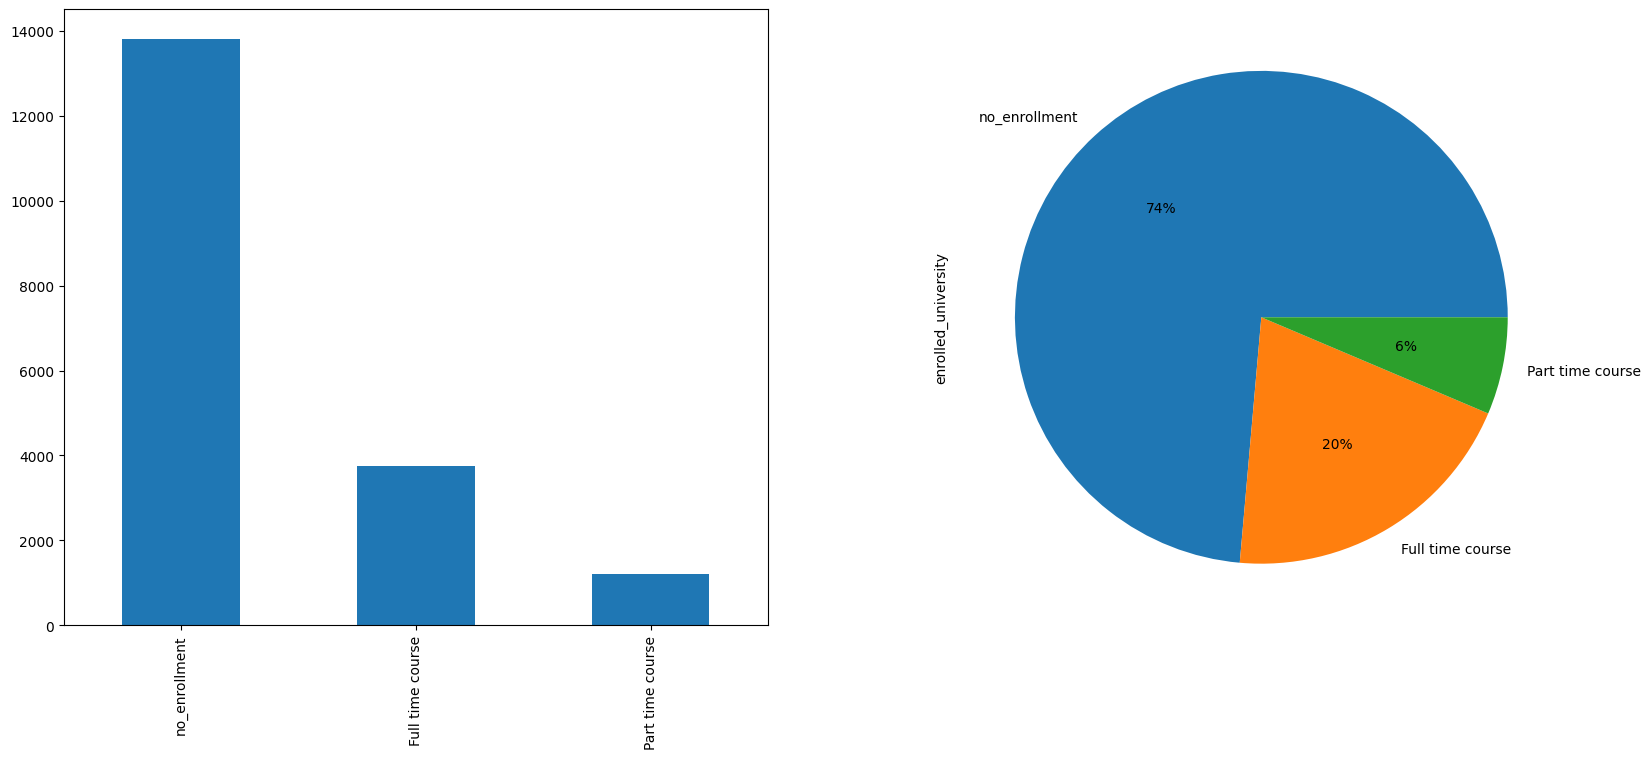

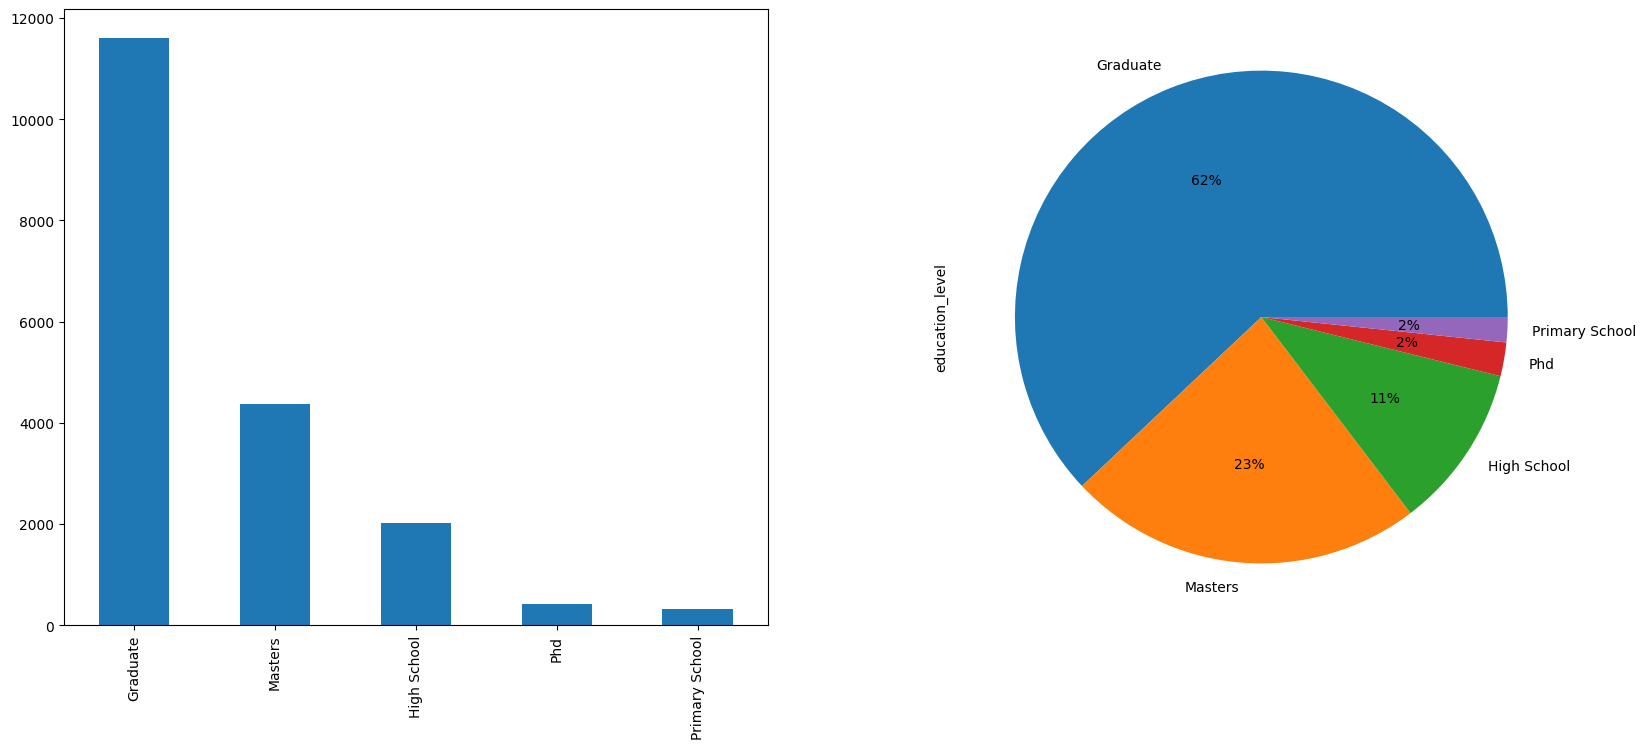

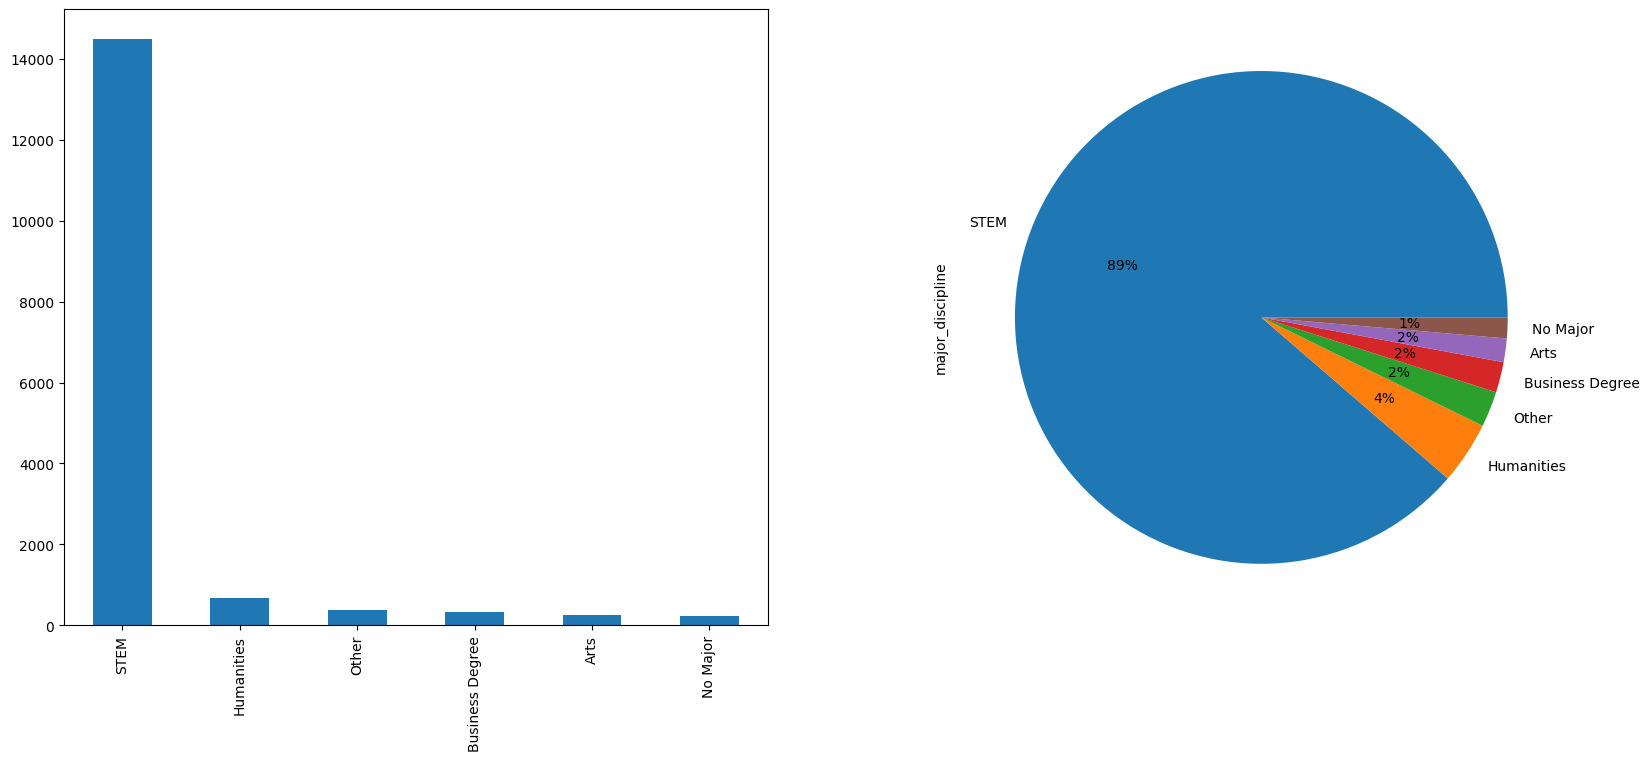

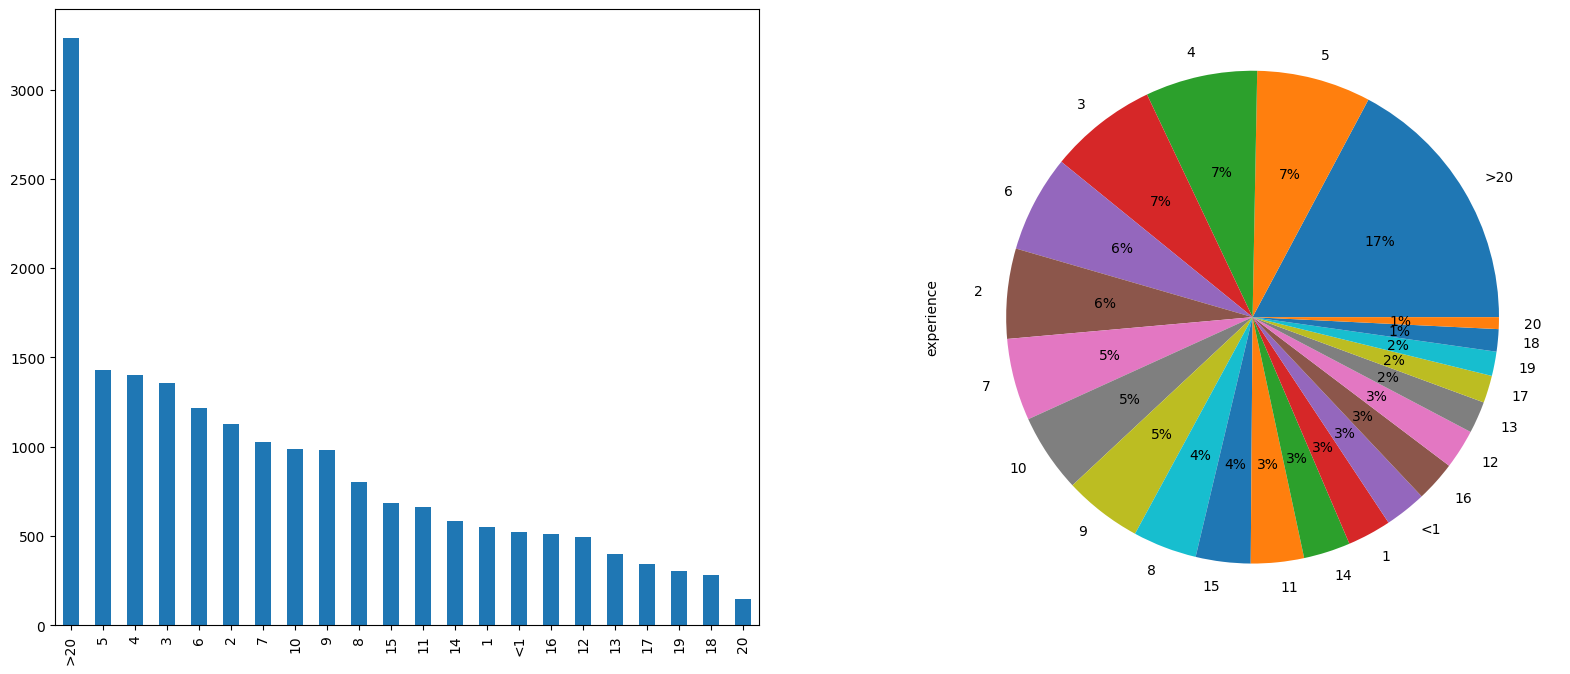

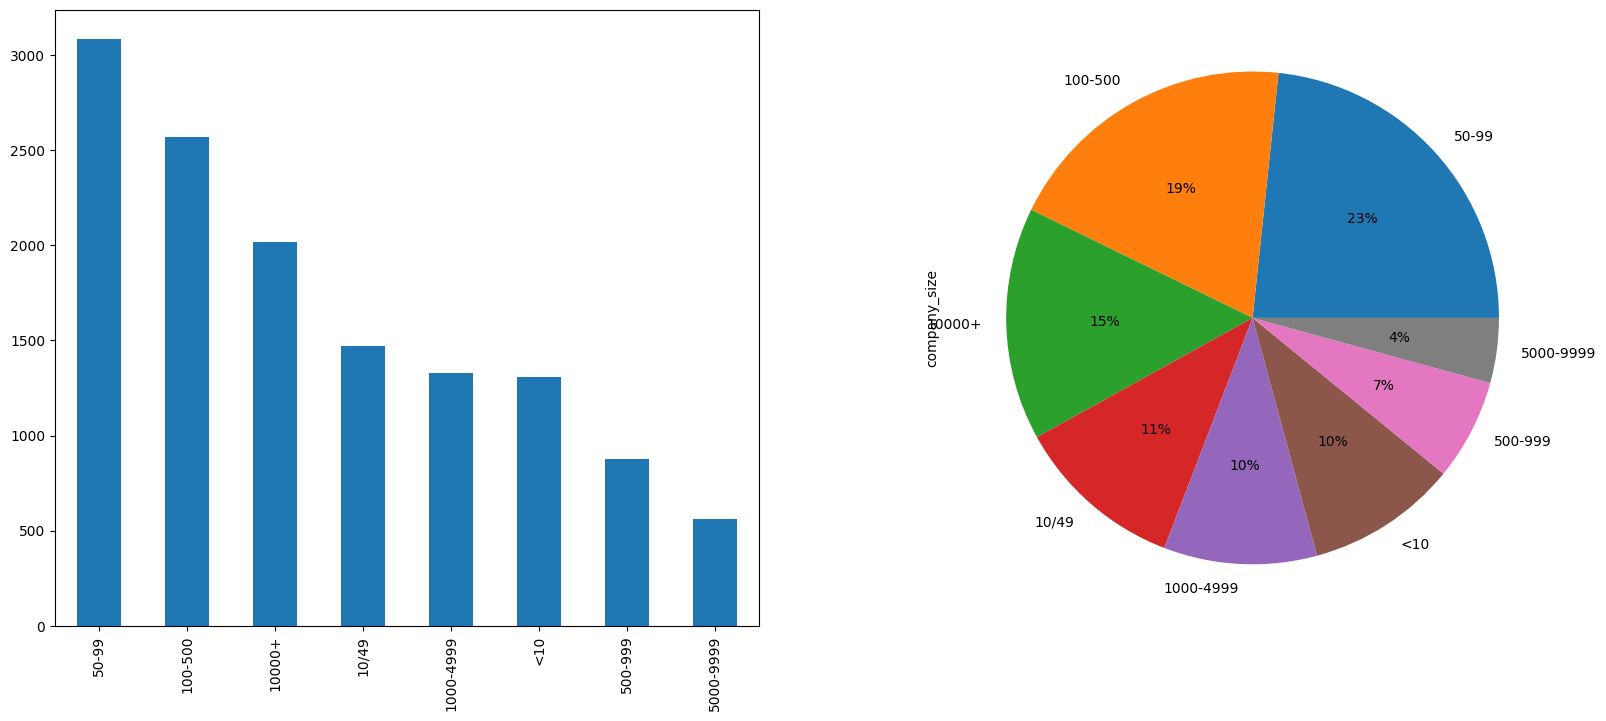

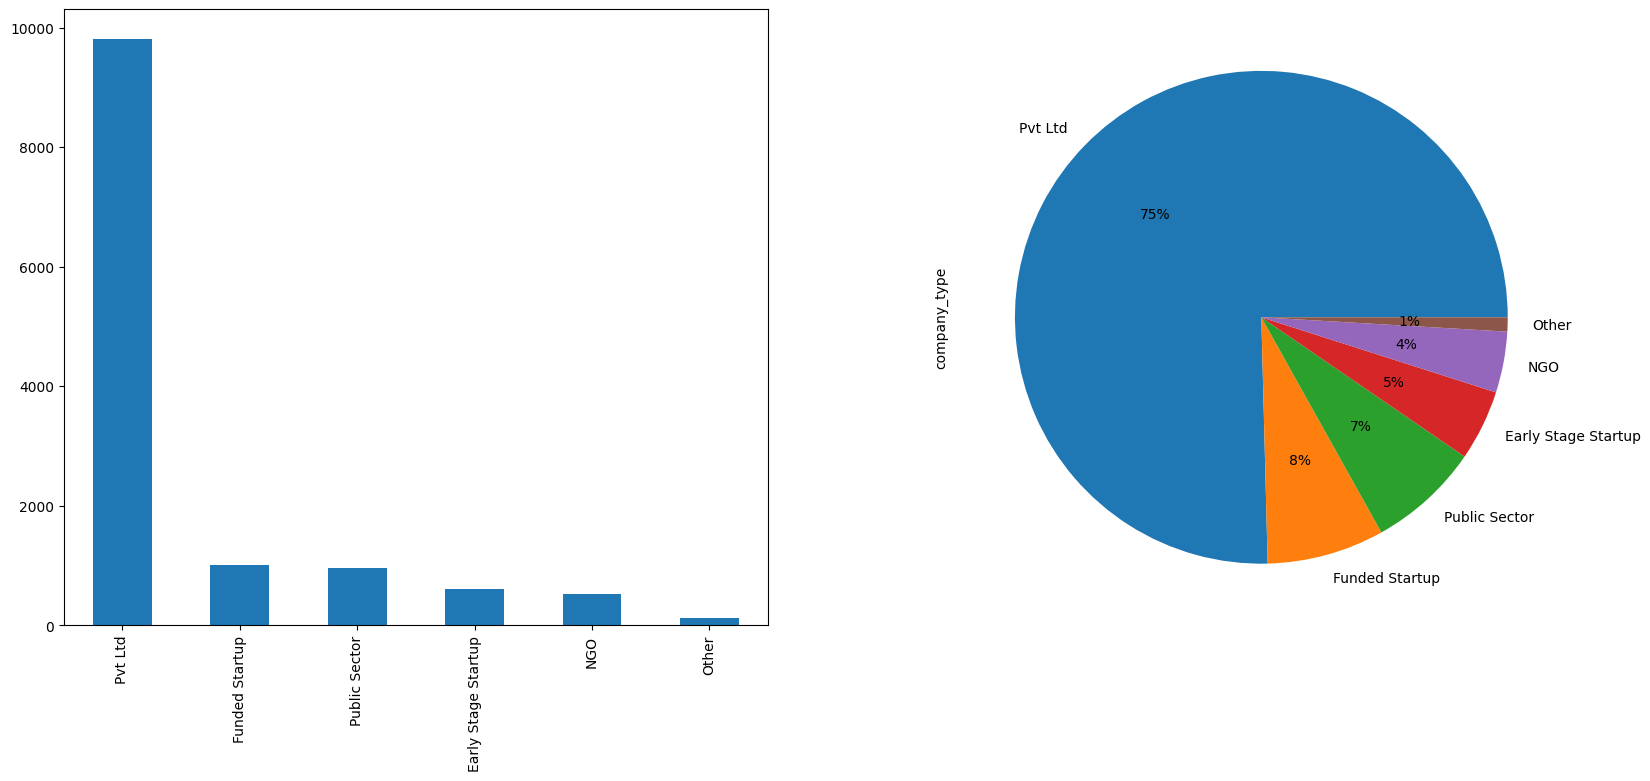

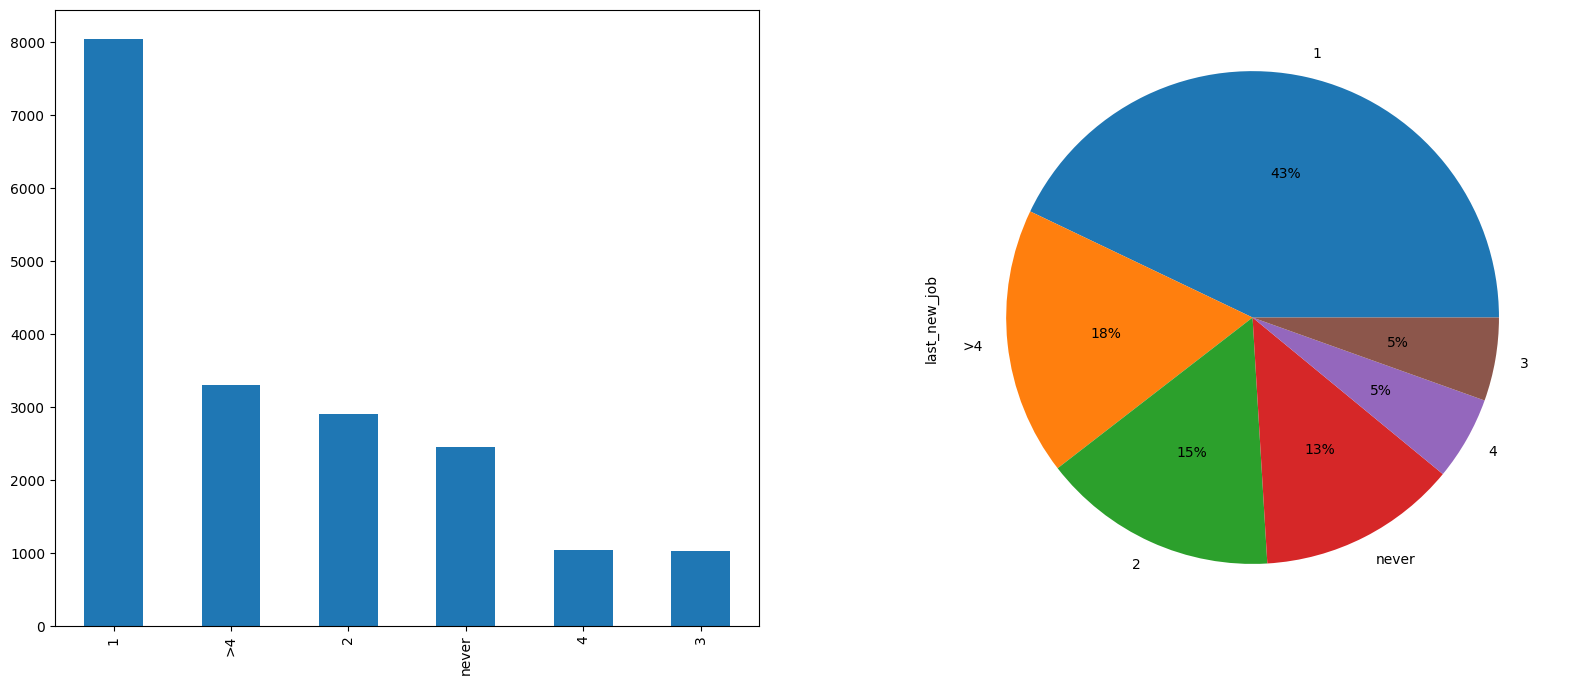

In [22]:
for feature in categorical_feature:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
    df[feature].value_counts().plot(kind='bar',ax=ax1)
    df[feature].value_counts().plot(kind='pie',autopct='%1.0f%%',ax=ax2)
    plt.show()

#### Target Columns Analysis

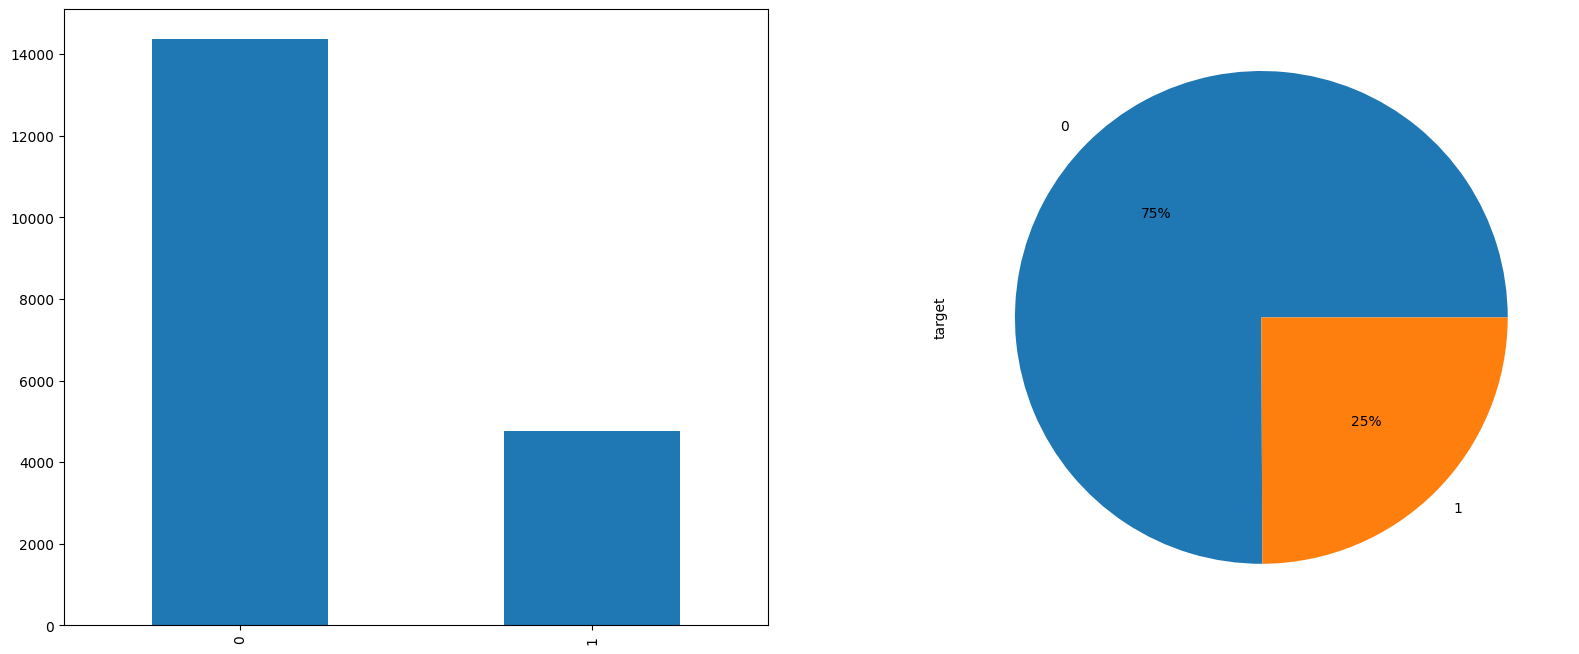

In [23]:

for feature in target:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
    df[feature].value_counts().plot(kind='bar',ax=ax1)
    df[feature].value_counts().plot(kind='pie',autopct='%1.0f%%',ax=ax2)
    plt.show()


### Observations
    - Numerica Features
        - Skewed data in numerica features
        - Also have Outliers
        - No null values
     
    - Categorical Features
        - city index have very high cardinality
        - null values 
    
    - Target Feature
        - imbalance data

### Multi-variant Analysis

city_development_index


<ipython-input-24-daed065f4911>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['target']==0][feature],hist=False,label='No')
<ipython-input-24-daed065f4911>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['target']==1][feature],hist=False,label='Yes')


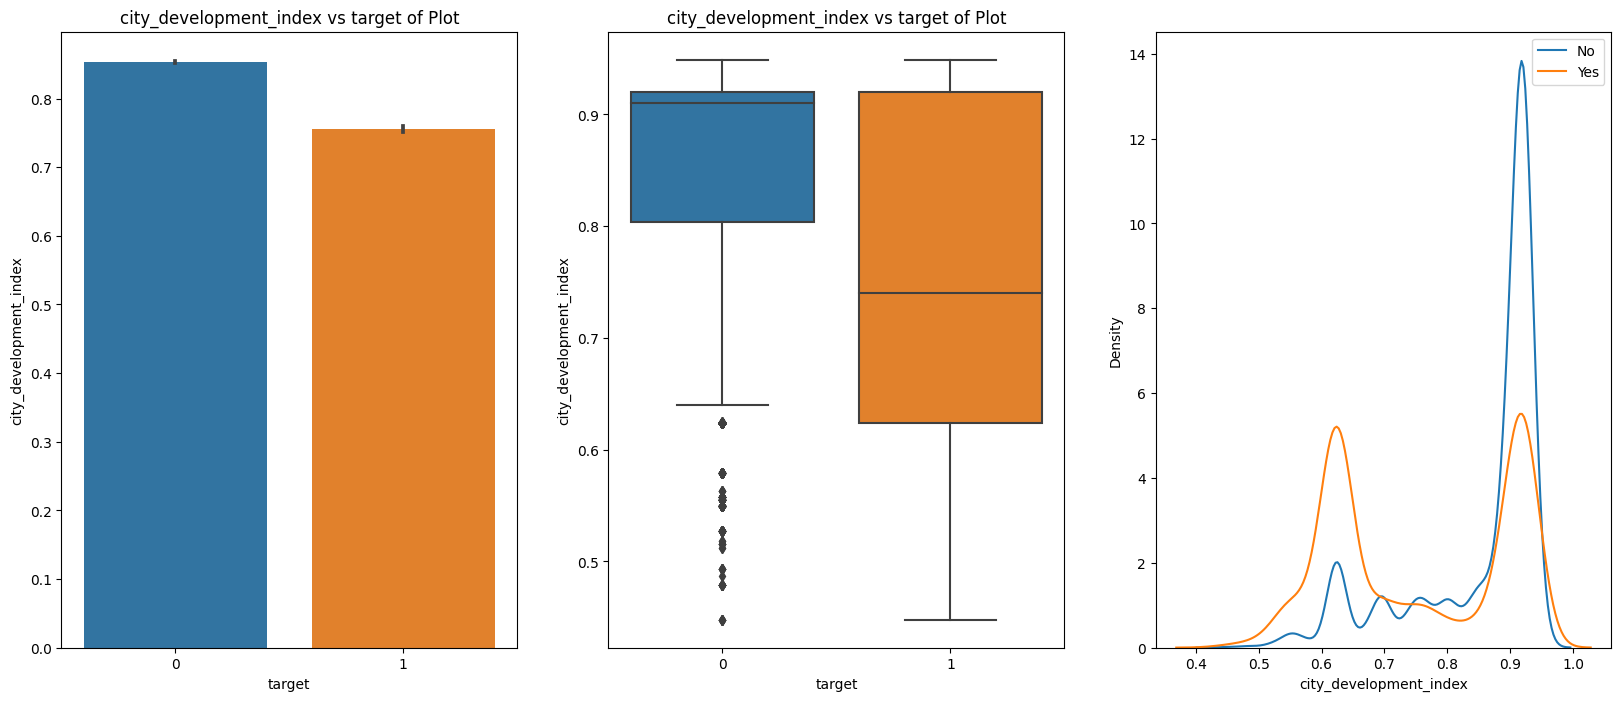

training_hours


<ipython-input-24-daed065f4911>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['target']==0][feature],hist=False,label='No')
<ipython-input-24-daed065f4911>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['target']==1][feature],hist=False,label='Yes')


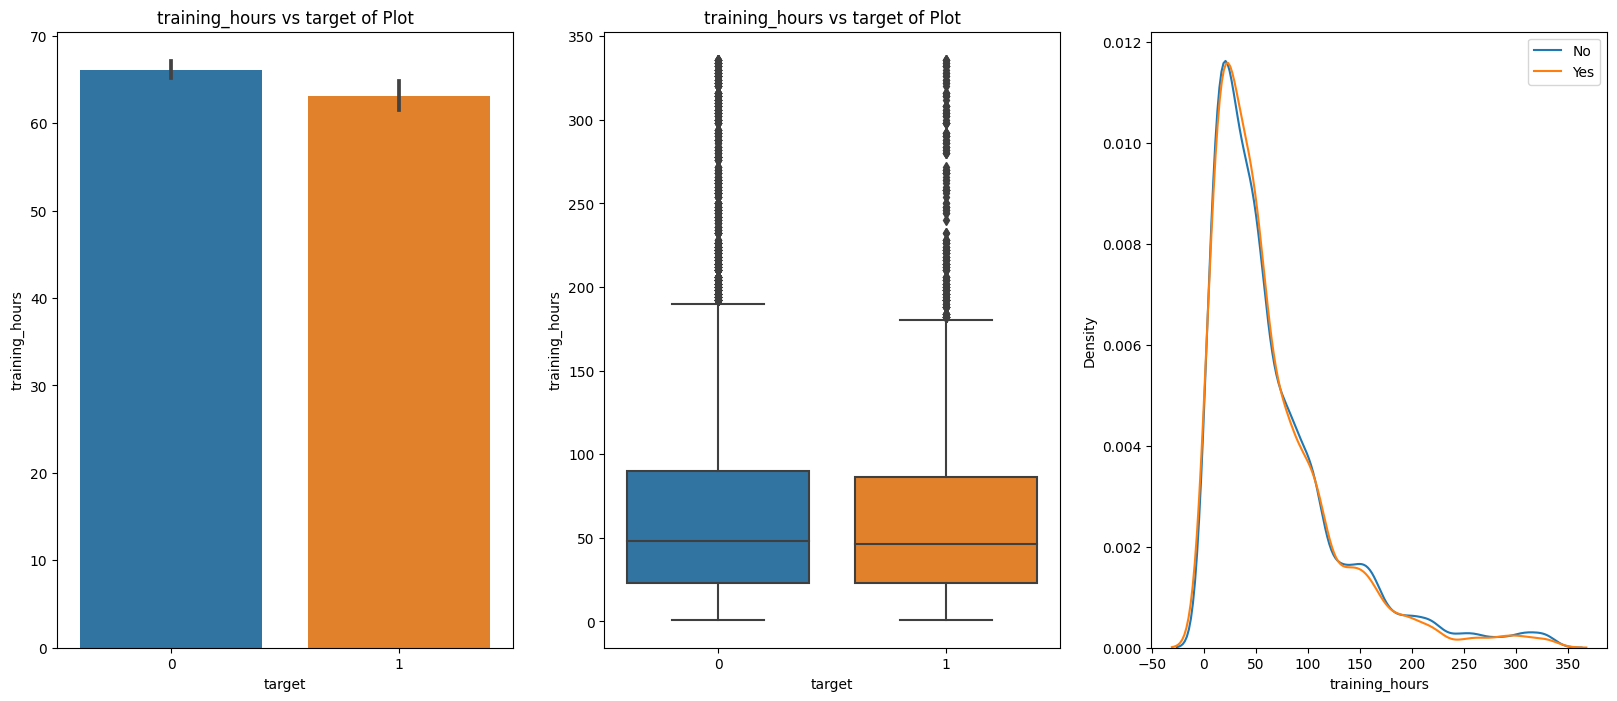

In [24]:
for feature in numeric_feature:
    print(feature)
    fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize=(20,8))
    sns.barplot(data=df, x=df[target[0]], y=df[feature],ax=ax1).set(title=f'{feature} vs {target[0]} of Plot')
    sns.boxplot(data=df, x=df[target[0]], y=df[feature],ax=ax2).set(title=f'{feature} vs {target[0]} of Plot')
    sns.distplot(df[df['target']==0][feature],hist=False,label='No')
    sns.distplot(df[df['target']==1][feature],hist=False,label='Yes')
    plt.legend()
    plt.show()

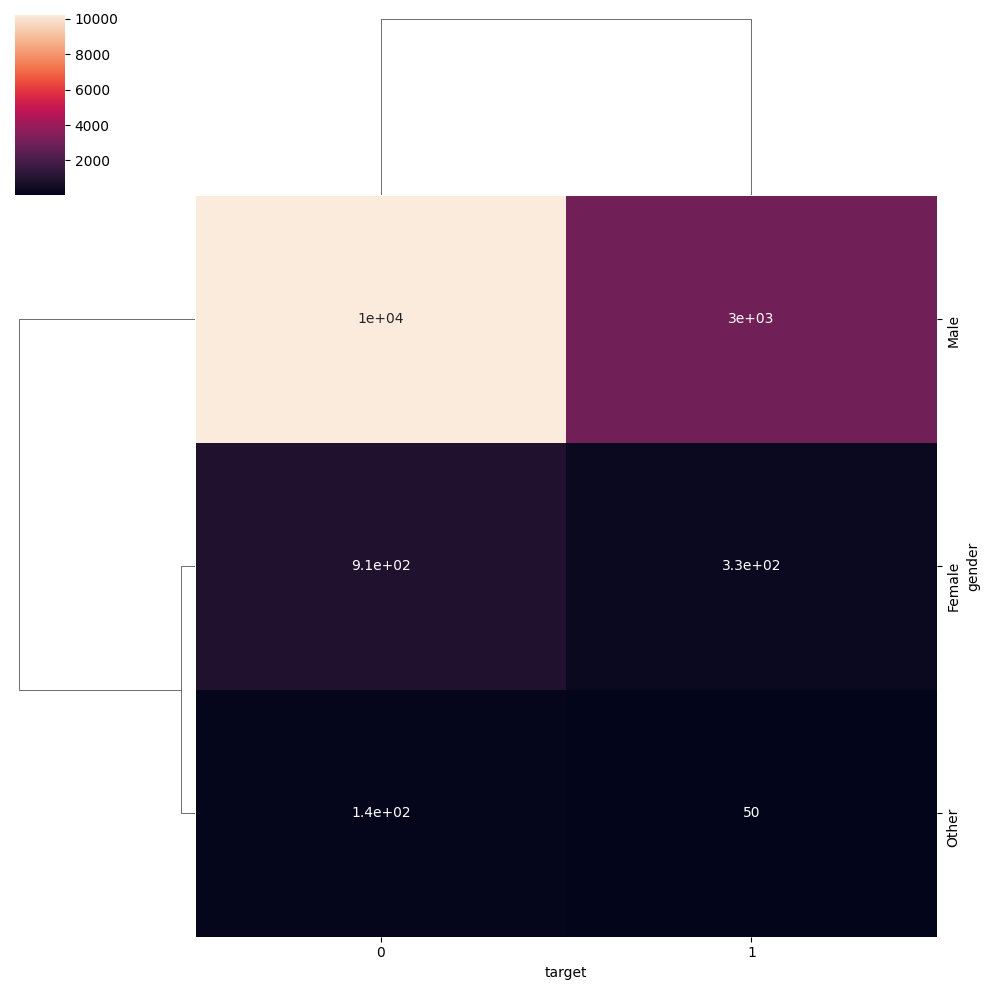

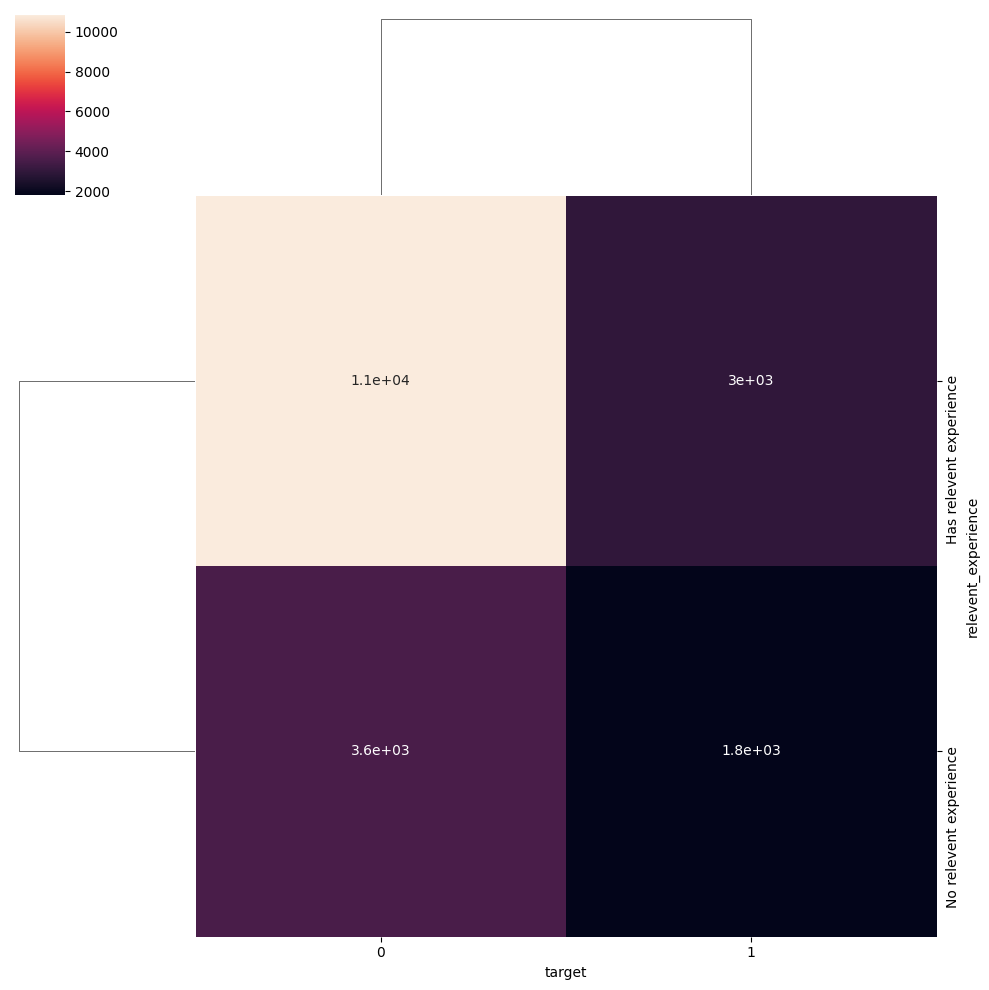

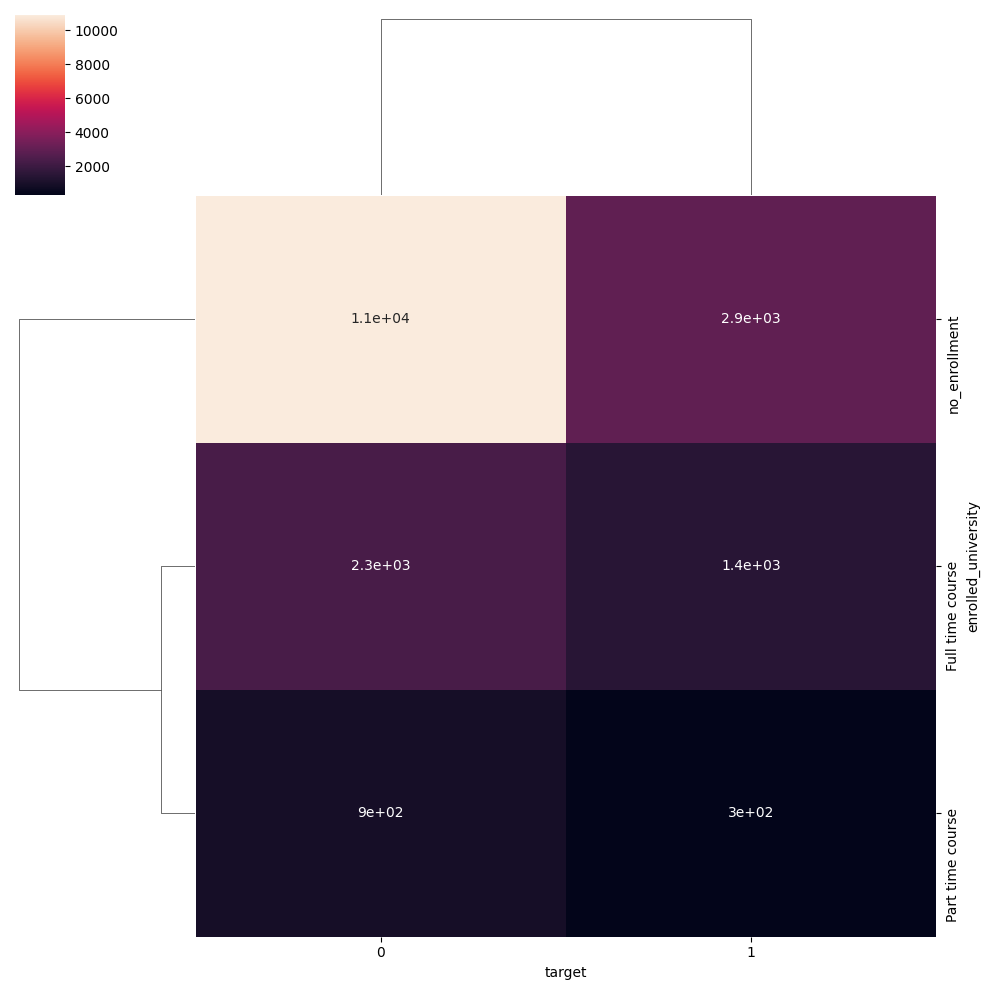

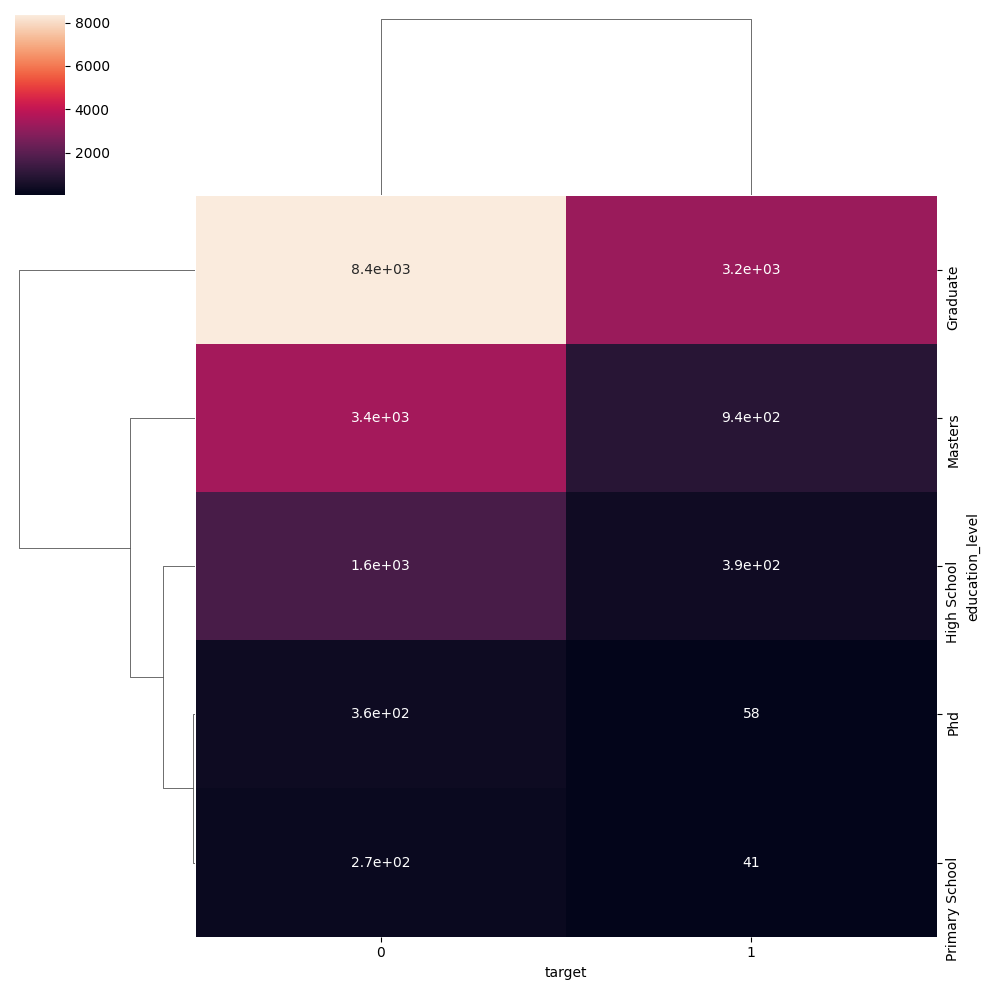

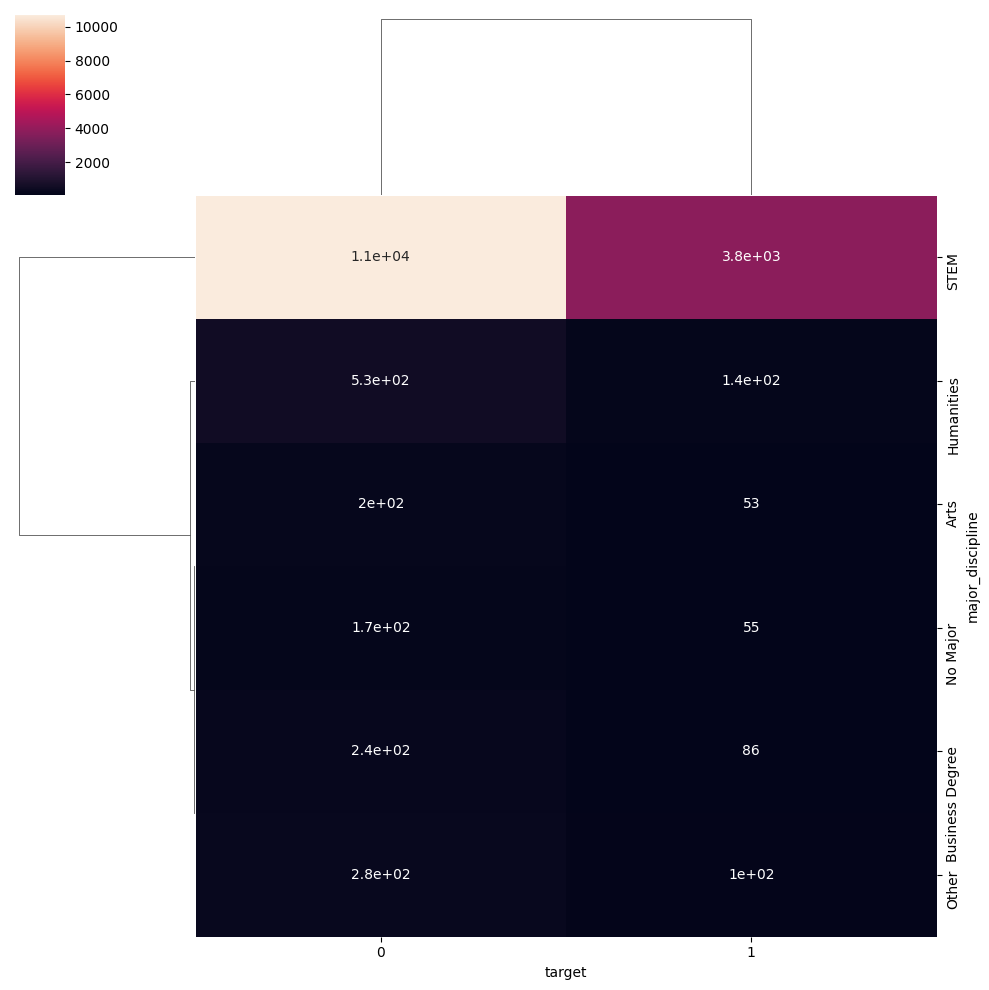

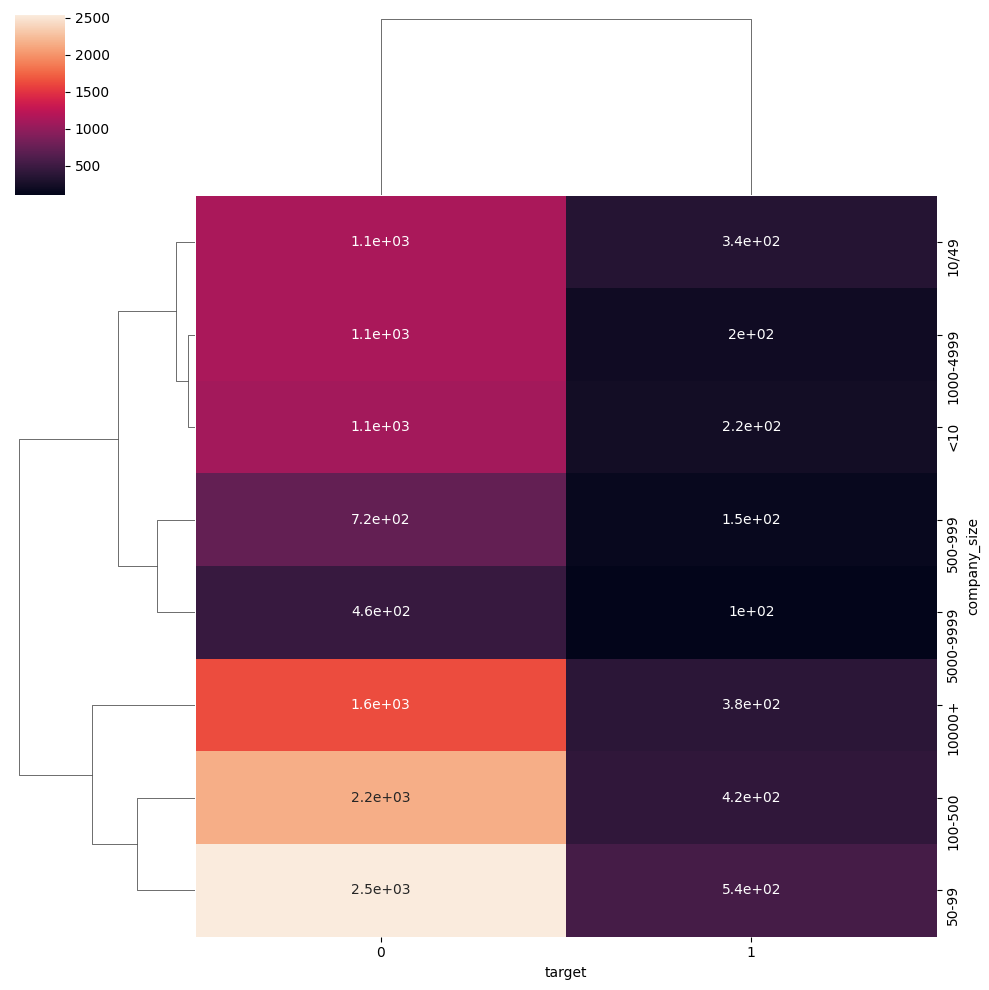

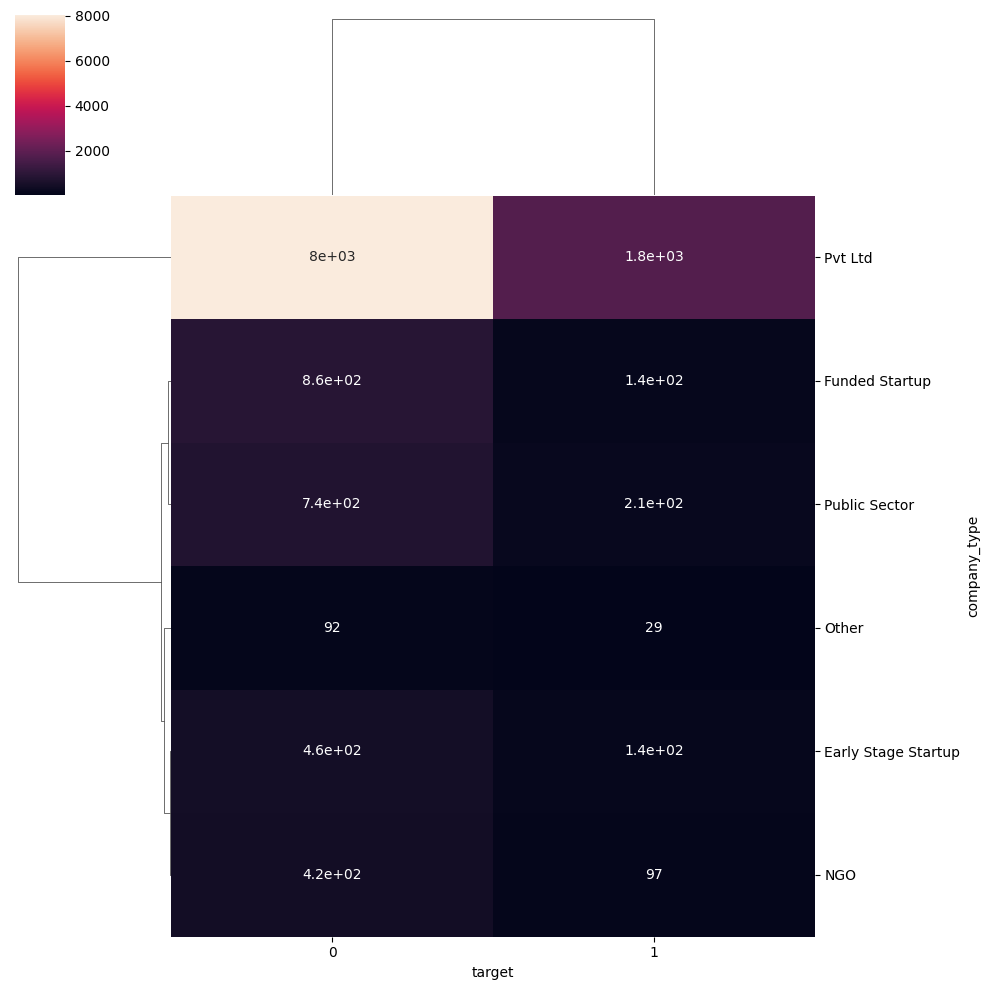

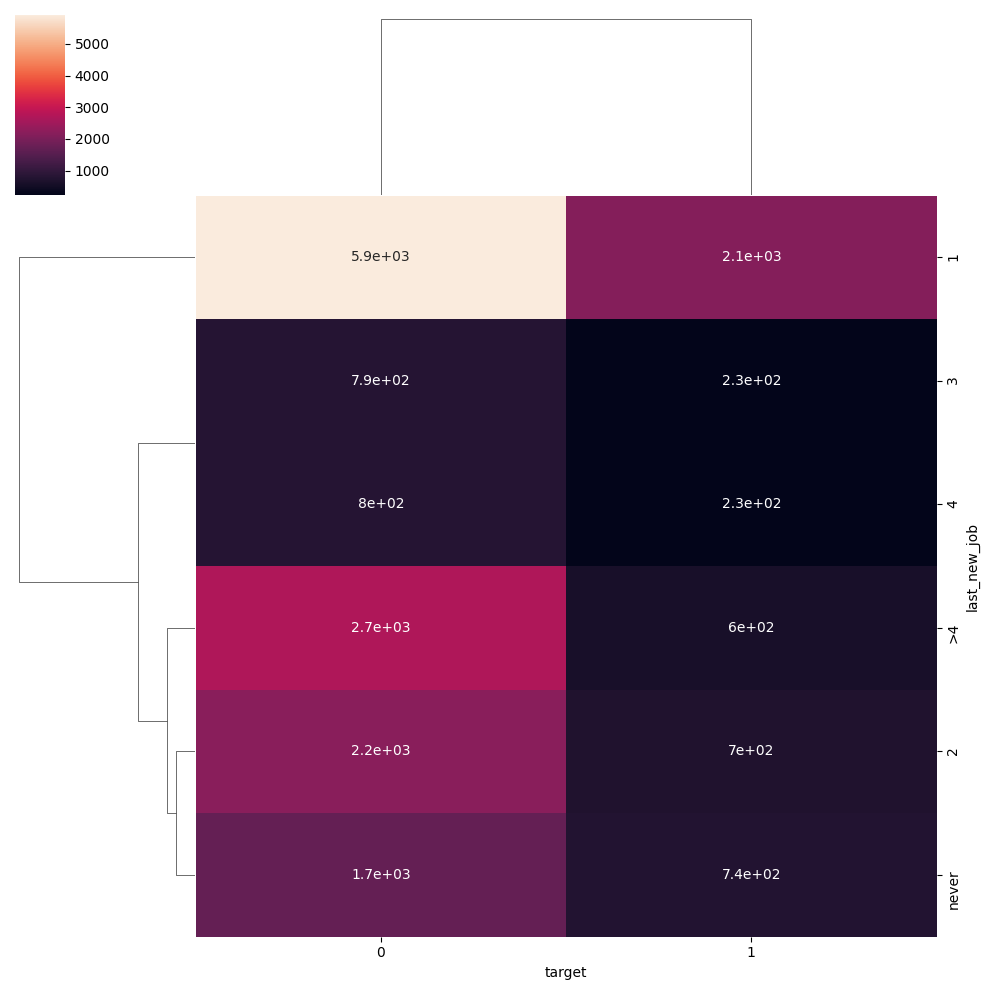

In [25]:
for feature in categorical_feature:
    if df[feature].nunique() < 15:
        sns.clustermap(pd.crosstab(df[feature],df[target[0]]),annot=True)
        plt.show()

### Observations
    - city index between 0.45 to 0.75 shows more interest to switch jobs.
    - we we saw gender feature males are showing more interent on switching jobs as compaired to females and others.
    - same goes with releavent experence and graduates. 
    - people we have working in a firm 1-2 year are showing interest in job switch.
    - Next step to see wheather they have any relations between themselfs.
    

In [26]:
df_query = df.loc[(df['city_development_index'] >= 0.45) & (df['city_development_index'] <= 0.75)]

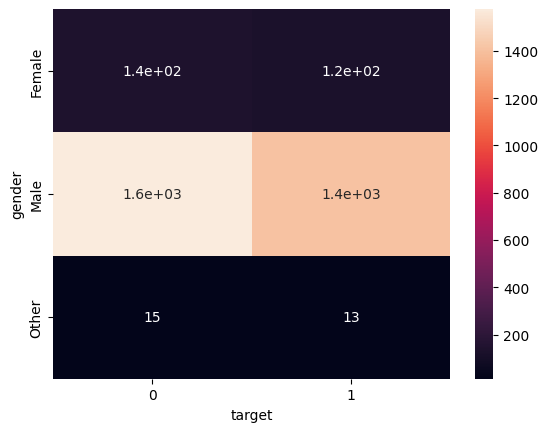

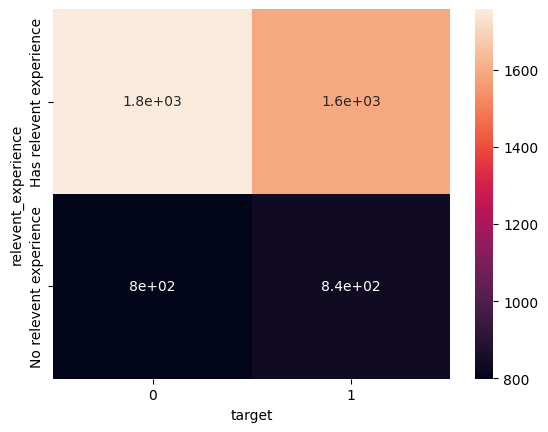

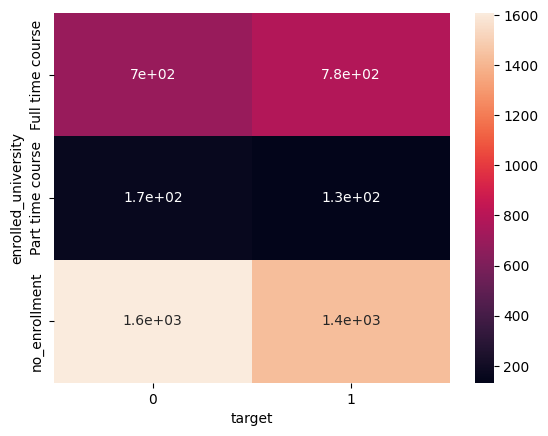

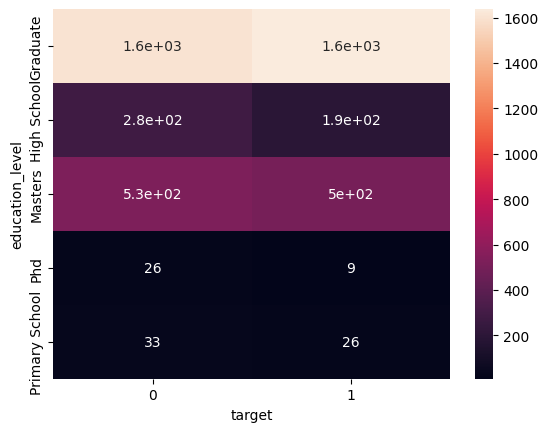

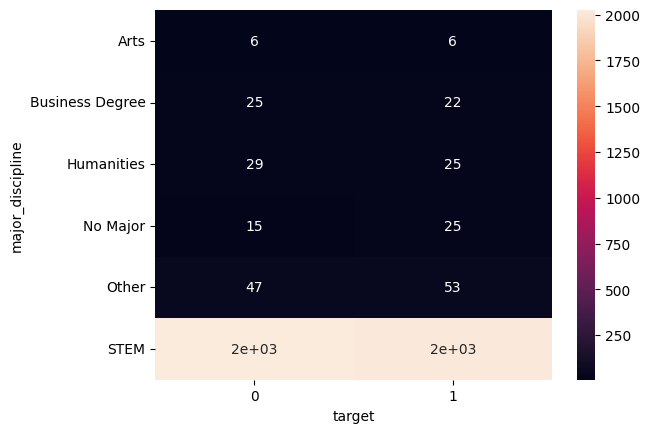

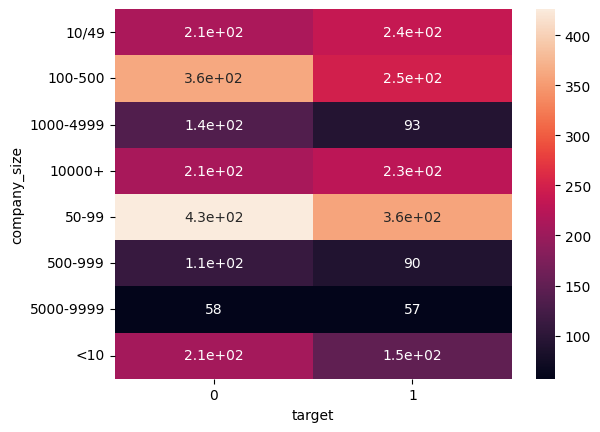

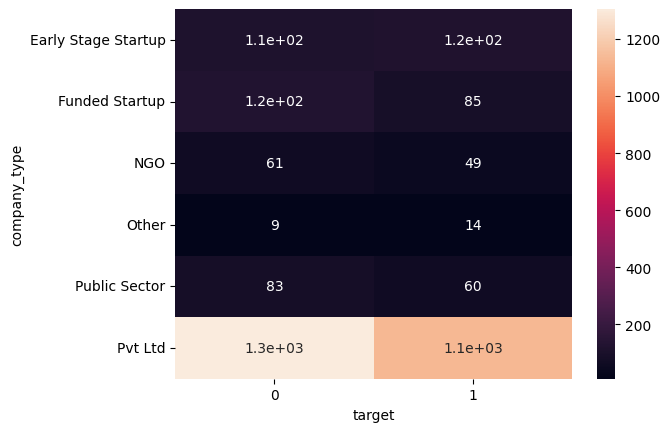

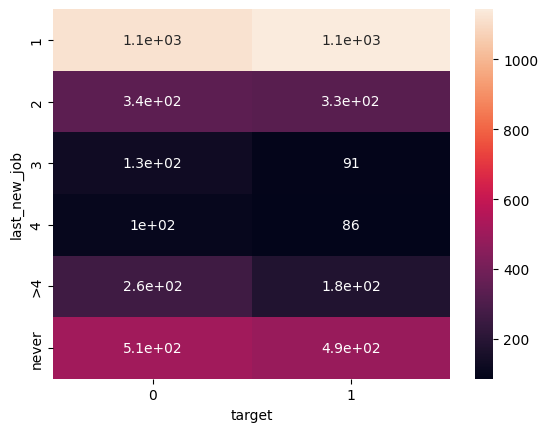

In [27]:
for feature in categorical_feature:
    if df_query[feature].nunique() < 15:
        sns.heatmap(pd.crosstab(df_query[feature],df_query[target[0]]),annot=True)
        plt.show()

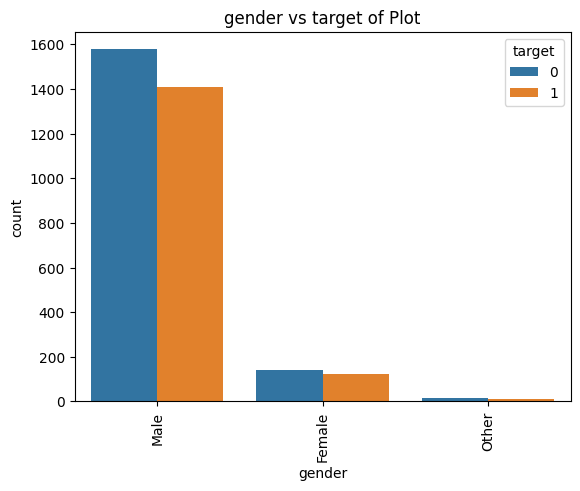

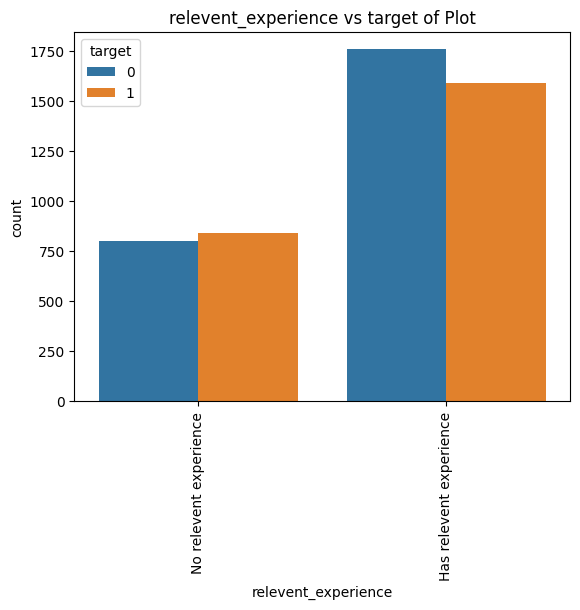

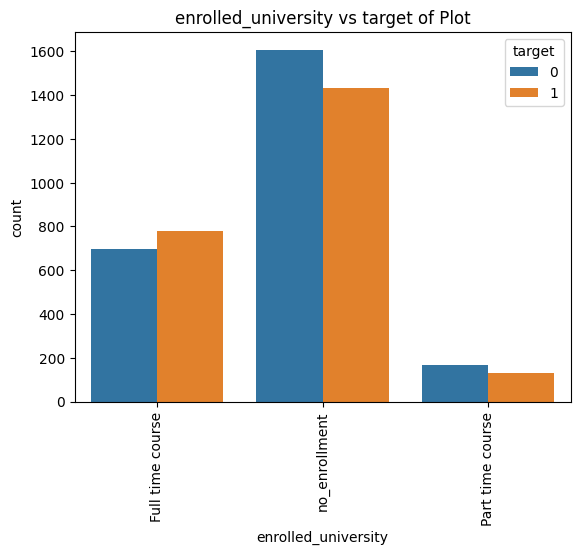

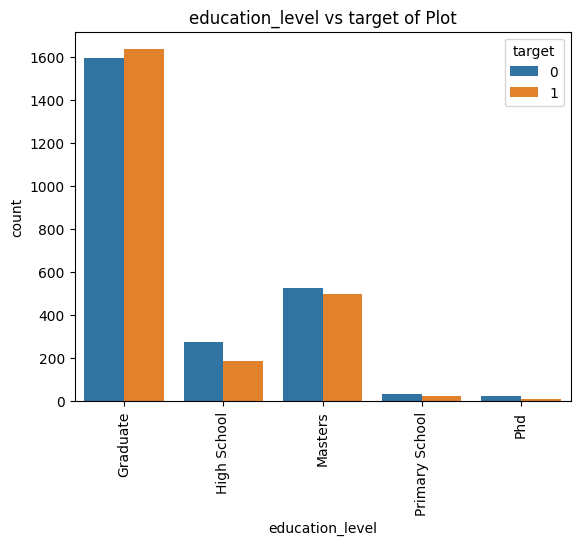

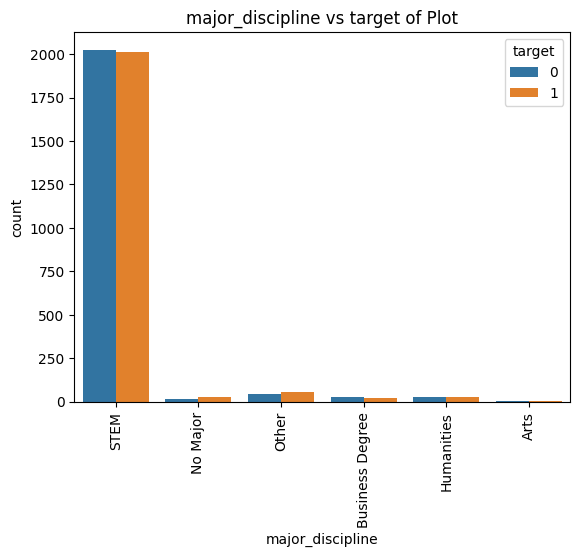

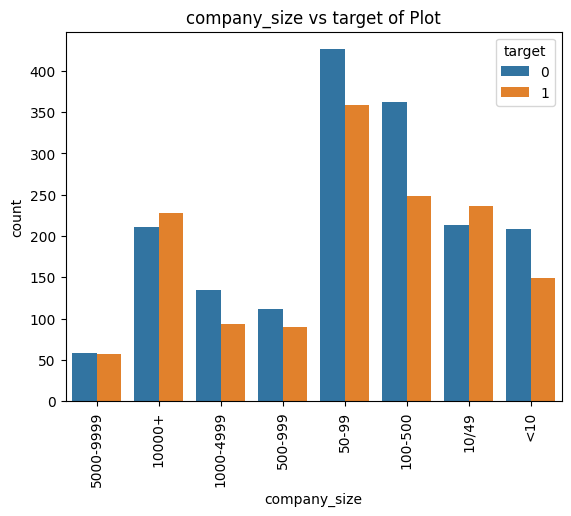

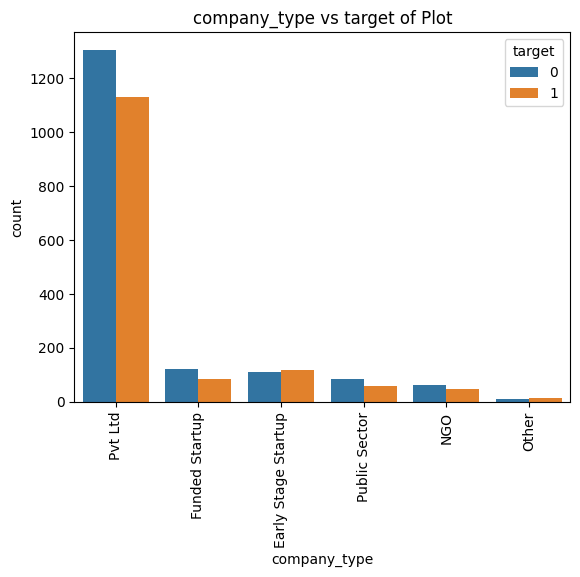

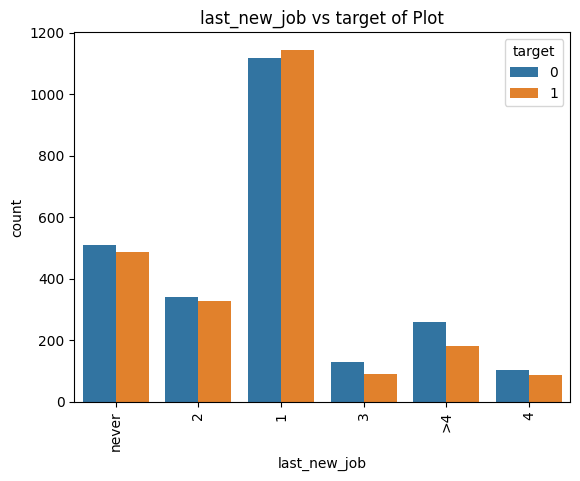

In [28]:
for feature in categorical_feature:
        if df_query[feature].nunique() < 15: 
            sns.countplot(x =df_query[feature], data = df_query, hue ='target').set(title=f'{feature} vs {target[0]} of Plot')
            plt.xticks(rotation=90)
            plt.show()

### Observations
    - The lower the city index of candidate the higher the probaility of candidate to switch jobs
    
    - Points of candidate who shows more interest in switching jobs 
         * Education (Graduated candidates)
         * relevant experence (Candidate with no relavant experience) 
         * Enrollment (candidates who are enrolled to any courses)
         * Major decipline (with no major and others)
         * Company type (who work in early stage startup candidates)
         * Company size (10000+ and 10-60)

## Data Preparation 

In [31]:
df.isnull().sum()

city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [32]:
df['experience'] = df['experience'].apply(lambda x : int(re.sub('[^A-Za-z0-9]+', '', x)) if ~isinstance(x,float) and isinstance(x,str) else x)

In [33]:
condlist = [((df['experience']>=1) & (df['experience']<=3)), ((df['experience']>3) & (df['experience']<=5)), ((df['experience']>5) & (df['experience']<=10)), ((df['experience']>10) & (df['experience']<=15)), (df['experience']>15)]
choicelist = ['Entry Level','Associate Level','Mid Senior Level','Senior','Director']


In [34]:
df['experience'] = np.select(condlist, choicelist, np.nan)

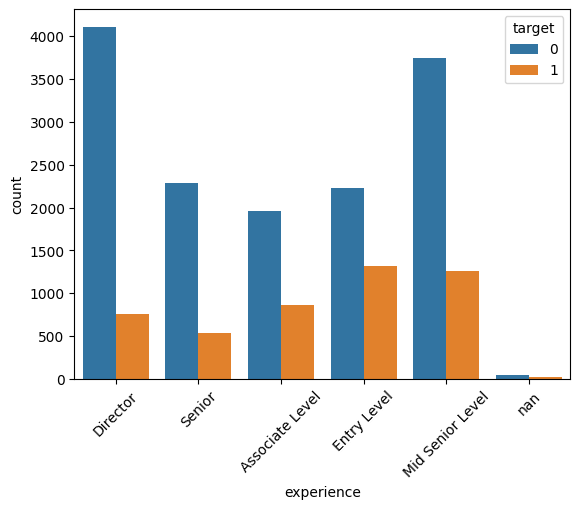

In [35]:
sns.countplot(data=df,x=df['experience'],hue=df['target'])
plt.xticks(rotation=45)
plt.show()

In [36]:
df['last_new_job'] = df['last_new_job'].apply(lambda x : re.sub('[^A-Za-z0-9]+', '', x) if ~isinstance(x,float) and isinstance(x,str) else x).replace('never','0').astype(float)

In [43]:
df['company_size']  = df['company_size'].apply(lambda x: re.split(r'[^\w]',x)  if ~isinstance(x,float) and isinstance(x,str) else x)

In [77]:
df['company_size'] = df['company_size'].apply(lambda x : [0 if value == '' else int(value) for value in x] if ~isinstance(x,float) and isinstance(x,list) else x)


In [91]:
df['company_size'] = df['company_size'].apply(lambda x : 'Start up' if ((x == [50, 99]) | (x == [0, 10]) | (x == [10, 49])) else 'Mid level Company' if ((x == [100, 500]) | (x == [500, 999])) else 'MNC' if ((x == [1000, 4999]) | (x == [5000, 9999]) | (x == [10000, 0])) else x )

In [103]:
df.drop('city',axis=1,inplace=True)

In [104]:
df.sample(5)

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
4758,0.848,NaN,Has relevent experience,no_enrollment,Graduate,STEM,Mid Senior Level,NaN,NaN,1.0,51,0
13333,0.754,Male,Has relevent experience,no_enrollment,Masters,STEM,Mid Senior Level,NaN,NaN,1.0,50,0
8707,0.920,NaN,Has relevent experience,Full time course,Graduate,STEM,Entry Level,NaN,NaN,1.0,108,1
9161,0.920,Male,Has relevent experience,Part time course,Graduate,STEM,Director,Start up,Funded Startup,1.0,7,1
18298,0.920,Male,No relevent experience,Full time course,Graduate,STEM,Mid Senior Level,Mid level Company,Public Sector,1.0,4,0


## Feature Engineering

In [106]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target'],axis=1), df['target'],test_size=0.2,random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15326, 11), (3832, 11), (15326,), (3832,))

In [182]:
pipe = Pipeline([
    # missing data indicator 
    ('missing_ind', AddMissingIndicator(
        variables=['gender', 'major_discipline',  'company_size','company_type'])),
    # missing categorical frequency data indicator 
    ('missing_categorical_feq', CategoricalImputer(
        variables=['gender', 'enrolled_university',  'education_level','major_discipline','company_size','company_type'])),
    # missing median 
    ('missing_median_imp', MeanMedianImputer(
        imputation_method='median',variables=['last_new_job'])),  
    # categorical onehot encoding 
    ('cat_onehot_encod', OneHotEncoder(
        drop_last=True,variables=['gender',	'relevent_experience','enrolled_university','major_discipline','company_size','company_type'])),   
    # categorical ordina encoding 
    ('cat_ordinal_encod', OrdinalEncoder(
        encoding_method='ordered',variables=['education_level','experience'])), 
    # yeojohnson transform  
    ('yeojohnson_transform', YeoJohnsonTransformer(
        variables=['last_new_job','city_development_index','training_hours'])),  
    # StandardScaler
    ('StandardScaler',StandardScaler())                  
])

In [183]:
pipe =  pipe.fit(X_train,y_train)

In [184]:
X_train_transform = pipe.transform(X_train)
X_test_transform = pipe.transform(X_test)

## Model & Evaluation

In [194]:
X_train_transform.shape[1]

31

In [200]:
model = Sequential()
model.add(Dense(32,activation='relu',input_dim=X_train_transform.shape[1]))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [201]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                1024      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,569
Trainable params: 1,569
Non-trainable params: 0
_________________________________________________________________


In [202]:
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [203]:
history = model.fit(X_train_transform, y_train, validation_data=(X_test_transform, y_test), epochs=10)

Epoch 1/10
479/479 [==============================] - 3s 4ms/step - loss: 0.5140 - accuracy: 0.7341 - val_loss: 0.4750 - val_accuracy: 0.7644
Epoch 2/10
479/479 [==============================] - 1s 3ms/step - loss: 0.4658 - accuracy: 0.7700 - val_loss: 0.4685 - val_accuracy: 0.7667
Epoch 3/10
479/479 [==============================] - 1s 3ms/step - loss: 0.4601 - accuracy: 0.7745 - val_loss: 0.4669 - val_accuracy: 0.7691
Epoch 4/10
479/479 [==============================] - 1s 3ms/step - loss: 0.4561 - accuracy: 0.7763 - val_loss: 0.4645 - val_accuracy: 0.7724
Epoch 5/10
479/479 [==============================] - 1s 2ms/step - loss: 0.4530 - accuracy: 0.7776 - val_loss: 0.4652 - val_accuracy: 0.7704
Epoch 6/10
479/479 [==============================] - 1s 2ms/step - loss: 0.4500 - accuracy: 0.7812 - val_loss: 0.4666 - val_accuracy: 0.7688
Epoch 7/10
479/479 [==============================] - 1s 2ms/step - loss: 0.4478 - accuracy: 0.7835 - val_loss: 0.4654 - val_accuracy: 0.7743
Epoch 

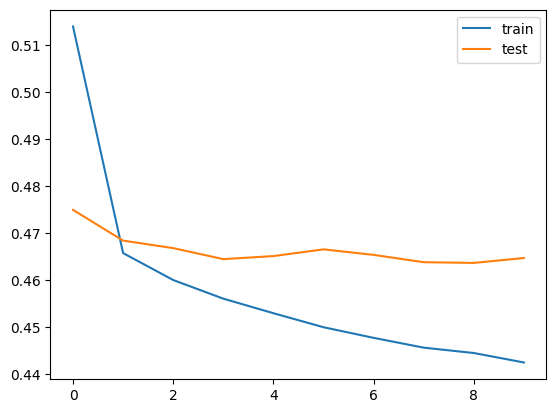

In [204]:

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

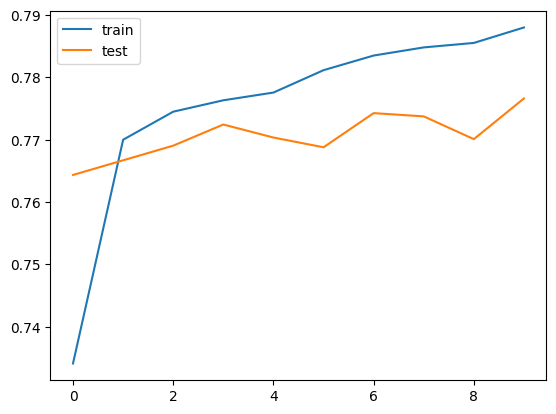

In [205]:

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()